# Laboratory exercise 4

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from transformers import (AlbertModel, AlbertTokenizer, BertModel,
                          BertTokenizer, DistilBertModel, DistilBertTokenizer,
                          RobertaModel, RobertaTokenizer)

## Read data

In [2]:
df = pd.read_csv('training.csv', sep='\t')

In [3]:
df

,file_name,misogynous,shaming,stereotype,objectification,violence,Text Transcription
0,1.jpg,0,0,0,0,0,Milk Milk.zip
1,10.jpg,1,0,0,0,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,1000.jpg,0,0,0,0,0,BREAKING NEWS: Russia releases photo of DONALD...
3,10000.jpg,0,0,0,0,0,MAN SEEKING WOMAN Ignad 18 O
4,10006.jpg,0,0,0,0,0,Me explaining the deep lore of. J.R.R. Tolkein...
...,...,...,...,...,...,...,...
9995,15002.jpg,0,0,0,0,0,WAITING FOR THE END OF THE COVID imgflip.com
9996,15003.jpg,0,0,0,0,0,SMART WOMEN ARE AROUND imgflip.com
9997,15004.jpg,0,0,0,0,0,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com
9998,15005.jpg,0,0,0,0,0,COOKING FOR MY WIFE imgflip.com


## Create models

In [4]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.encodings = tokenizer(df['Text Transcription'].tolist(), padding='longest',
                                   return_tensors='pt')
        # self.encodings = [
        #     tokenizer(text, padding='longest', return_tensors="pt")
        #     for text in df['Text Transcription']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = {k: v[idx] for k, v in self.encodings.items()}
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(self.labels[idx], dtype=torch.float)
        }


class DatasetA(BaseDataset):
    def __init__(self, df, tokenizer):
        super().__init__(df, tokenizer)
        self.labels = pd.get_dummies(df['misogynous']).values


class DatasetB(BaseDataset):
    def __init__(self, df, tokenizer):
        super().__init__(df, tokenizer)
        label_map = {'shaming': 0, 'stereotype': 1, 'objectification': 2, 'violence': 3}
        self.labels = df[['shaming', 'stereotype', 'objectification', 'violence']].values

In [5]:
class TransformerClassifier(nn.Module):
    def __init__(self, transformer_model, num_labels):
        super(TransformerClassifier, self).__init__()

        self.transformer = transformer_model
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(
            self.transformer.config.hidden_size, num_labels)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask, return_bert_output=False):
        transformer_out = self.transformer(
            input_ids=input_id, attention_mask=mask, return_dict=False)
        if len(transformer_out) == 1:
            # distilbert returns only a tuple with a single tensor
            # and by the shape it is the whole history, IDK WHY!?!?
            pooled_output = transformer_out[0][:, -1, :]
        else:
            pooled_output = transformer_out[1]
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.softmax(linear_output)
        if return_bert_output:
            return final_layer, pooled_output
        return final_layer


In [6]:
def train_val_test_split(df):
    df_train_val, df_test = train_test_split(
        df, test_size=0.1, random_state=42, shuffle=True)
    df_train, df_val = train_test_split(df_train_val, test_size=0.1, random_state=42)

    return df_train, df_val, df_test

In [7]:
def train(model, tokenizer, df_train, df_val, subtask, learning_rate=1e-5, batch_size=32, epochs=5, use_cuda=True):
    if subtask.lower() == 'a':
        output_len = 1
        dataset_train = DatasetA(df_train, tokenizer)
        dataset_val = DatasetA(df_val, tokenizer)
    elif subtask.lower() == 'b':
        output_len = 5
        dataset_train = DatasetB(df_train, tokenizer)
        dataset_val = DatasetB(df_val, tokenizer)
    else:
        raise ValueError('Subtask must be either A or B')

    train_dataloader = torch.utils.data.DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(
        dataset_val, batch_size=batch_size)

    use_cuda = use_cuda and torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')
    print(f'Training on device: {device}')

    if use_cuda:
        model = model.cuda()
        
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for data in tqdm(train_dataloader):

            train_target = data['target'].to(device)
            mask = data['attention_mask'].to(device)
            input_id = data['input_ids'].to(device)

            output = model(input_id, mask)
            
            _, preds = torch.max(output, dim=1)

            batch_loss = criterion(output, train_target)
            total_loss_train += batch_loss.item()

            acc = (preds == torch.max(train_target, dim=1)[1]).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for data in val_dataloader:

                val_target = data['target'].to(device)
                mask = data['attention_mask'].to(device)
                input_id = data['input_ids'].to(device)

                output = model(input_id, mask)
                
                _, preds = torch.max(output, dim=1)

                batch_loss = criterion(output, val_target)
                total_loss_val += batch_loss.item()

                acc = (preds == torch.max(val_target, dim=1)[1]).sum().item()
                total_acc_val += acc

        print(
            f'Epochs: {epoch_num + 1} '
            f'| Train Loss: {total_loss_train / len(df_train): .3f} '
            f'| Train Accuracy: {total_acc_train / len(df_train): .3f} '
            f'| Val Loss: {total_loss_val / len(df_val): .3f} '
            f'| Val Accuracy: {total_acc_val / len(df_val): .3f}')


In [8]:
def evaluate(model, tokenizer, df_test, subtask, batch_size=32, use_cuda=True):
    if subtask.lower() == 'a':
        test_dataset = DatasetA(df_test, tokenizer)
    elif subtask.lower() == 'b':
        test_dataset = DatasetB(df_test, tokenizer)
    else:
        raise ValueError('Subtask must be either A or B')

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size)

    use_cuda = use_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    
    bert_outputs = []
    masks = []
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in test_dataloader:

            test_target = data['target'].to(device)
            mask = data['attention_mask'].to(device)
            input_id = data['input_ids'].to(device)

            output, bert_output = model(
                input_id, mask, return_bert_output=True)

            _, true = torch.max(test_target, dim=1)
            _, preds = torch.max(output, dim=1)
            
            bert_outputs += bert_output.cpu()
            masks += mask.cpu()
            y_true += true.tolist()
            y_pred += preds.tolist()
            acc = (preds == torch.max(test_target, dim=1)[1]).sum().item()
            total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_dataset): .3f}')
    return bert_outputs, masks, y_true, y_pred


In [9]:
def get_bert_tokenizer_and_model():
    return (
        BertTokenizer.from_pretrained('bert-base-uncased'),
        BertModel.from_pretrained('bert-base-uncased')
    )


def get_albert_tokenizer_and_model():
    return (
        AlbertTokenizer.from_pretrained('albert-base-v2'),
        AlbertModel.from_pretrained('albert-base-v2')
    )


def get_robert_tokenizer_and_model():
    return (
        RobertaTokenizer.from_pretrained('roberta-base'),
        RobertaModel.from_pretrained('roberta-base')
    )


def get_distilbert_tokenizer_and_model():
    return (
        DistilBertTokenizer.from_pretrained('distilbert-base-uncased'),
        DistilBertModel.from_pretrained('distilbert-base-uncased')
    )

## Subtask A

In [10]:
target_names_A = ['not_mysogynous', 'mysogynous']

In [11]:
model_info_A = []
class_reports_A = {}
tokenizer_model_funcs = {
    'bert': get_bert_tokenizer_and_model,
    'albert': get_albert_tokenizer_and_model,
    'robert': get_robert_tokenizer_and_model,
    'distilbert': get_distilbert_tokenizer_and_model   
}
df_train, df_val, df_test = train_val_test_split(df)
for name, func in tokenizer_model_funcs.items():
    torch.cuda.empty_cache()
    tokenizer, bert_model = func()
    model = TransformerClassifier(bert_model, num_labels=2)
    train(model, tokenizer, df_train, df_val, 'A', learning_rate=1e-5, batch_size=32, epochs=4, use_cuda=True)
    bert_outputs, masks, y_true, y_pred = evaluate(model, tokenizer, df_test, 'A', batch_size=32, use_cuda=True)
    # print(y_true)
    # print(y_pred)
    model_info_A.append((bert_outputs, masks, y_true, y_pred))
    class_report = classification_report(y_true, y_pred, target_names=target_names_A)
    print(class_report)
    class_reports_A[name] = class_report

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on device: cuda


100%|██████████| 254/254 [01:23<00:00,  3.03it/s]


Epochs: 1 | Train Loss:  0.018 | Train Accuracy:  0.725 | Val Loss:  0.016 | Val Accuracy:  0.802


100%|██████████| 254/254 [01:24<00:00,  3.02it/s]


Epochs: 2 | Train Loss:  0.015 | Train Accuracy:  0.850 | Val Loss:  0.016 | Val Accuracy:  0.802


100%|██████████| 254/254 [01:24<00:00,  3.02it/s]


Epochs: 3 | Train Loss:  0.013 | Train Accuracy:  0.901 | Val Loss:  0.016 | Val Accuracy:  0.784


100%|██████████| 254/254 [01:24<00:00,  3.01it/s]


Epochs: 4 | Train Loss:  0.012 | Train Accuracy:  0.928 | Val Loss:  0.016 | Val Accuracy:  0.792
Test Accuracy:  0.802
                precision    recall  f1-score   support

not_mysogynous       0.75      0.89      0.81       484
    mysogynous       0.88      0.72      0.79       516

      accuracy                           0.80      1000
     macro avg       0.81      0.80      0.80      1000
  weighted avg       0.81      0.80      0.80      1000



Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on device: cuda


100%|██████████| 254/254 [01:43<00:00,  2.44it/s]


Epochs: 1 | Train Loss:  0.021 | Train Accuracy:  0.541 | Val Loss:  0.022 | Val Accuracy:  0.498


100%|██████████| 254/254 [01:44<00:00,  2.44it/s]


Epochs: 2 | Train Loss:  0.022 | Train Accuracy:  0.511 | Val Loss:  0.022 | Val Accuracy:  0.488


100%|██████████| 254/254 [01:44<00:00,  2.44it/s]


Epochs: 3 | Train Loss:  0.020 | Train Accuracy:  0.592 | Val Loss:  0.017 | Val Accuracy:  0.766


100%|██████████| 254/254 [01:44<00:00,  2.44it/s]


Epochs: 4 | Train Loss:  0.017 | Train Accuracy:  0.757 | Val Loss:  0.017 | Val Accuracy:  0.782
Test Accuracy:  0.787
                precision    recall  f1-score   support

not_mysogynous       0.75      0.84      0.79       484
    mysogynous       0.83      0.73      0.78       516

      accuracy                           0.79      1000
     macro avg       0.79      0.79      0.79      1000
  weighted avg       0.79      0.79      0.79      1000



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on device: cuda


100%|██████████| 254/254 [01:40<00:00,  2.53it/s]


Epochs: 1 | Train Loss:  0.018 | Train Accuracy:  0.705 | Val Loss:  0.016 | Val Accuracy:  0.796


100%|██████████| 254/254 [01:40<00:00,  2.53it/s]


Epochs: 2 | Train Loss:  0.015 | Train Accuracy:  0.828 | Val Loss:  0.016 | Val Accuracy:  0.800


100%|██████████| 254/254 [01:40<00:00,  2.53it/s]


Epochs: 3 | Train Loss:  0.014 | Train Accuracy:  0.875 | Val Loss:  0.016 | Val Accuracy:  0.801


100%|██████████| 254/254 [01:40<00:00,  2.53it/s]


Epochs: 4 | Train Loss:  0.013 | Train Accuracy:  0.900 | Val Loss:  0.016 | Val Accuracy:  0.797
Test Accuracy:  0.797
                precision    recall  f1-score   support

not_mysogynous       0.78      0.81      0.79       484
    mysogynous       0.82      0.78      0.80       516

      accuracy                           0.80      1000
     macro avg       0.80      0.80      0.80      1000
  weighted avg       0.80      0.80      0.80      1000



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on device: cuda


100%|██████████| 254/254 [00:43<00:00,  5.81it/s]


Epochs: 1 | Train Loss:  0.018 | Train Accuracy:  0.710 | Val Loss:  0.016 | Val Accuracy:  0.791


100%|██████████| 254/254 [00:43<00:00,  5.79it/s]


Epochs: 2 | Train Loss:  0.015 | Train Accuracy:  0.826 | Val Loss:  0.016 | Val Accuracy:  0.798


100%|██████████| 254/254 [00:43<00:00,  5.78it/s]


Epochs: 3 | Train Loss:  0.014 | Train Accuracy:  0.877 | Val Loss:  0.016 | Val Accuracy:  0.801


100%|██████████| 254/254 [00:43<00:00,  5.78it/s]


Epochs: 4 | Train Loss:  0.013 | Train Accuracy:  0.912 | Val Loss:  0.017 | Val Accuracy:  0.776
Test Accuracy:  0.792
                precision    recall  f1-score   support

not_mysogynous       0.74      0.89      0.81       484
    mysogynous       0.87      0.70      0.78       516

      accuracy                           0.79      1000
     macro avg       0.80      0.80      0.79      1000
  weighted avg       0.81      0.79      0.79      1000



In [12]:
for name, report in class_reports_A.items():
    print(name)
    print(report)
    print()

bert
                precision    recall  f1-score   support

not_mysogynous       0.75      0.89      0.81       484
    mysogynous       0.88      0.72      0.79       516

      accuracy                           0.80      1000
     macro avg       0.81      0.80      0.80      1000
  weighted avg       0.81      0.80      0.80      1000


albert
                precision    recall  f1-score   support

not_mysogynous       0.75      0.84      0.79       484
    mysogynous       0.83      0.73      0.78       516

      accuracy                           0.79      1000
     macro avg       0.79      0.79      0.79      1000
  weighted avg       0.79      0.79      0.79      1000


robert
                precision    recall  f1-score   support

not_mysogynous       0.78      0.81      0.79       484
    mysogynous       0.82      0.78      0.80       516

      accuracy                           0.80      1000
     macro avg       0.80      0.80      0.80      1000
  weighted avg     

In [16]:
BEST_MODEL_INDEX = 0

/home/nca/anaconda3/envs/martin/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

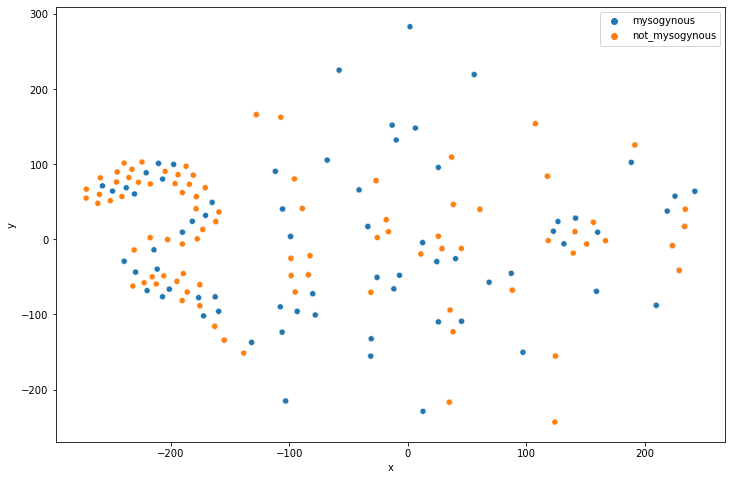

In [17]:
bert_outputs, masks, y_true, y_pred = model_info_A[BEST_MODEL_INDEX]
bert_averaged = torch.div(torch.stack(bert_outputs).sum(dim=1), torch.stack(masks).sum(dim=1, keepdim=True))
bert_dim_reduced_embeds = TSNE(init='pca', learning_rate='auto').fit_transform(bert_averaged.numpy())
df_tsne = pd.DataFrame(bert_dim_reduced_embeds, columns=['x', 'y'])
_, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x='x', y='y', data=df_tsne, hue=[target_names_A[p] for p in y_pred])

## Subtask B

In [18]:
target_names_B = ['shaming', 'stereotype', 'objectification', 'violence']

In [19]:
model_info_B = []
class_reports_B = {}
tokenizer_model_funcs = {
    'bert': get_bert_tokenizer_and_model,
    'albert': get_albert_tokenizer_and_model,
    'robert': get_robert_tokenizer_and_model,
    'distilbert': get_distilbert_tokenizer_and_model   
}
df_train, df_val, df_test = train_val_test_split(df[df['misogynous'] == 1])
for name, func in tokenizer_model_funcs.items():
    torch.cuda.empty_cache()
    tokenizer, bert_model = func()
    model = TransformerClassifier(bert_model, num_labels=4)
    train(model, tokenizer, df_train, df_val, 'B', learning_rate=1e-5, batch_size=32, epochs=4, use_cuda=True)
    bert_outputs, masks, y_true, y_pred = evaluate(model, tokenizer, df_test, 'B', batch_size=32, use_cuda=True)
    # print(y_true)
    # print(y_pred)
    model_info_B.append((bert_outputs, masks, y_true, y_pred))
    class_report = classification_report(y_true, y_pred, target_names=target_names_B)
    print(class_report)
    class_reports_B[name] = class_report

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training on device: cuda


100%|██████████| 127/127 [00:27<00:00,  4.65it/s]


Epochs: 1 | Train Loss:  0.060 | Train Accuracy:  0.432 | Val Loss:  0.059 | Val Accuracy:  0.484


100%|██████████| 127/127 [00:27<00:00,  4.63it/s]


Epochs: 2 | Train Loss:  0.057 | Train Accuracy:  0.497 | Val Loss:  0.058 | Val Accuracy:  0.513


100%|██████████| 127/127 [00:27<00:00,  4.62it/s]


Epochs: 3 | Train Loss:  0.055 | Train Accuracy:  0.555 | Val Loss:  0.058 | Val Accuracy:  0.509


100%|██████████| 127/127 [00:27<00:00,  4.61it/s]


Epochs: 4 | Train Loss:  0.054 | Train Accuracy:  0.579 | Val Loss:  0.058 | Val Accuracy:  0.520
Test Accuracy:  0.514
                 precision    recall  f1-score   support

        shaming       1.00      0.01      0.01       141
     stereotype       0.61      0.76      0.67       226
objectification       0.39      0.79      0.52       108
       violence       0.00      0.00      0.00        25

       accuracy                           0.51       500
      macro avg       0.50      0.39      0.30       500
   weighted avg       0.64      0.51      0.42       500



/home/nca/anaconda3/envs/martin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nca/anaconda3/envs/martin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nca/anaconda3/envs/martin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some

Training on device: cuda


100%|██████████| 127/127 [00:33<00:00,  3.76it/s]


Epochs: 1 | Train Loss:  0.060 | Train Accuracy:  0.411 | Val Loss:  0.060 | Val Accuracy:  0.458


100%|██████████| 127/127 [00:33<00:00,  3.75it/s]


Epochs: 2 | Train Loss:  0.058 | Train Accuracy:  0.477 | Val Loss:  0.059 | Val Accuracy:  0.504


100%|██████████| 127/127 [00:33<00:00,  3.74it/s]


Epochs: 3 | Train Loss:  0.056 | Train Accuracy:  0.509 | Val Loss:  0.059 | Val Accuracy:  0.502


100%|██████████| 127/127 [00:33<00:00,  3.74it/s]


Epochs: 4 | Train Loss:  0.056 | Train Accuracy:  0.533 | Val Loss:  0.059 | Val Accuracy:  0.493
Test Accuracy:  0.524
                 precision    recall  f1-score   support

        shaming       0.00      0.00      0.00       141
     stereotype       0.61      0.81      0.69       226
objectification       0.40      0.74      0.52       108
       violence       0.00      0.00      0.00        25

       accuracy                           0.52       500
      macro avg       0.25      0.39      0.30       500
   weighted avg       0.36      0.52      0.42       500



/home/nca/anaconda3/envs/martin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nca/anaconda3/envs/martin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nca/anaconda3/envs/martin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some

Training on device: cuda


100%|██████████| 127/127 [00:27<00:00,  4.60it/s]


Epochs: 1 | Train Loss:  0.059 | Train Accuracy:  0.420 | Val Loss:  0.059 | Val Accuracy:  0.476


100%|██████████| 127/127 [00:27<00:00,  4.59it/s]


Epochs: 2 | Train Loss:  0.057 | Train Accuracy:  0.492 | Val Loss:  0.059 | Val Accuracy:  0.489


100%|██████████| 127/127 [00:27<00:00,  4.58it/s]


Epochs: 3 | Train Loss:  0.055 | Train Accuracy:  0.542 | Val Loss:  0.058 | Val Accuracy:  0.489


100%|██████████| 127/127 [00:27<00:00,  4.58it/s]


Epochs: 4 | Train Loss:  0.054 | Train Accuracy:  0.608 | Val Loss:  0.058 | Val Accuracy:  0.511
Test Accuracy:  0.546
                 precision    recall  f1-score   support

        shaming       0.86      0.13      0.22       141
     stereotype       0.61      0.81      0.70       226
objectification       0.40      0.67      0.50       108
       violence       0.00      0.00      0.00        25

       accuracy                           0.55       500
      macro avg       0.47      0.40      0.35       500
   weighted avg       0.60      0.55      0.49       500



/home/nca/anaconda3/envs/martin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nca/anaconda3/envs/martin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nca/anaconda3/envs/martin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some

Training on device: cuda


100%|██████████| 127/127 [00:14<00:00,  8.88it/s]


Epochs: 1 | Train Loss:  0.059 | Train Accuracy:  0.424 | Val Loss:  0.060 | Val Accuracy:  0.476


100%|██████████| 127/127 [00:14<00:00,  8.87it/s]


Epochs: 2 | Train Loss:  0.057 | Train Accuracy:  0.497 | Val Loss:  0.060 | Val Accuracy:  0.480


100%|██████████| 127/127 [00:14<00:00,  8.86it/s]


Epochs: 3 | Train Loss:  0.055 | Train Accuracy:  0.540 | Val Loss:  0.059 | Val Accuracy:  0.498


100%|██████████| 127/127 [00:14<00:00,  8.85it/s]


Epochs: 4 | Train Loss:  0.054 | Train Accuracy:  0.563 | Val Loss:  0.059 | Val Accuracy:  0.493
Test Accuracy:  0.518
                 precision    recall  f1-score   support

        shaming       1.00      0.01      0.01       141
     stereotype       0.61      0.77      0.68       226
objectification       0.39      0.77      0.52       108
       violence       0.00      0.00      0.00        25

       accuracy                           0.52       500
      macro avg       0.50      0.39      0.30       500
   weighted avg       0.64      0.52      0.42       500



/home/nca/anaconda3/envs/martin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nca/anaconda3/envs/martin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nca/anaconda3/envs/martin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
for name, report in class_reports_B.items():
    print(name)
    print(report)
    print()

bert
                 precision    recall  f1-score   support

        shaming       1.00      0.01      0.01       141
     stereotype       0.61      0.76      0.67       226
objectification       0.39      0.79      0.52       108
       violence       0.00      0.00      0.00        25

       accuracy                           0.51       500
      macro avg       0.50      0.39      0.30       500
   weighted avg       0.64      0.51      0.42       500


albert
                 precision    recall  f1-score   support

        shaming       0.00      0.00      0.00       141
     stereotype       0.61      0.81      0.69       226
objectification       0.40      0.74      0.52       108
       violence       0.00      0.00      0.00        25

       accuracy                           0.52       500
      macro avg       0.25      0.39      0.30       500
   weighted avg       0.36      0.52      0.42       500


robert
                 precision    recall  f1-score   support

   

## Conclusion

All bert based tokenizers and models show a similar performance. Compared to the models from lab 2 I got better results.
But for lab2 I didn't filter out the memes with misogynous == 1, so they are not really comparable.